### Xinlin Ying  001535622
### Import Library

Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.
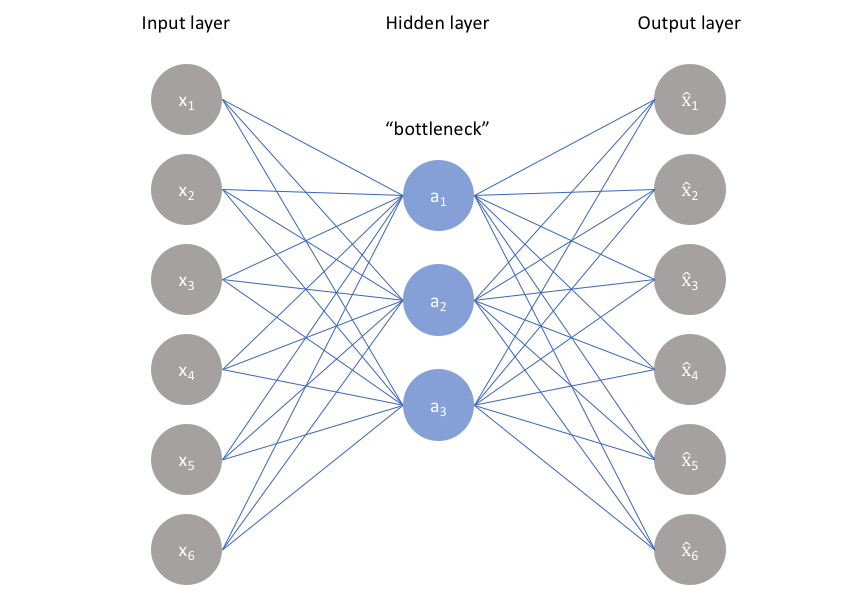

In [1]:
import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
from tensorflow.keras.datasets import fashion_mnist
from google.colab import drive
from tensorflow.keras.layers import Conv2D
from keras.models import Model, load_model
from keras.layers import *
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from keras.models import Sequential
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea

/Users/ava/opt/conda/envs/tf/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


build an autoencoder to perform dimensionality reduction on the fashion_mnist dataset.
First, Load the training and test set and display a few of the images to make sure everything is loaded correctly.

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


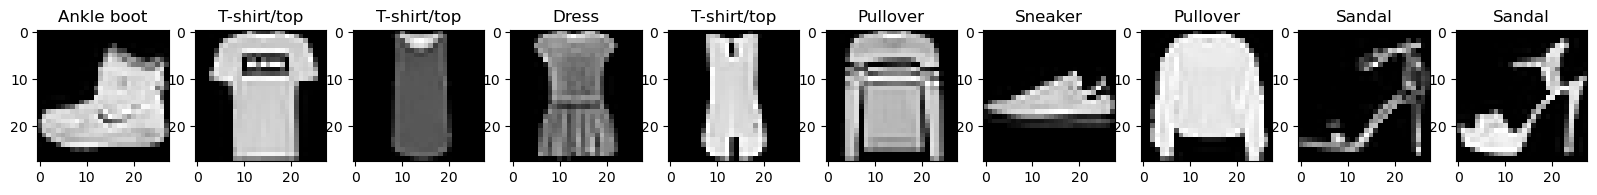

In [2]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
 
print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))
 
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(trainX[i], cmap='gray')
    ax[i].set_title(labeldict[trainy[i]])
    

#### Build the train and text sample

In [3]:
# normalizing pixel intensities
trainX = trainX/255
testX = testX/255
#reshaping data into single dimension
train_data = np.reshape(trainX, (60000, 28*28))
test_data = np.reshape(testX, (10000, 28*28))
print (train_data.shape, test_data.shape)

(60000, 784) (10000, 784)


#### Build the autoencoder. I give two latent variables, so that we can compare this approach to other dimensionality reduction techniques by visualizing the images on a plane.

In [4]:
trainX = trainX.reshape(-1, 28, 28, 1)
testX = testX.reshape(-1, 28, 28, 1)

def make_and_fit():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(2, activation='relu')(x)

    encoder = Model(inputs=inputs, outputs=encoded)
    
    encoded_inputs = Input(shape=(2,))

    x = Dense(4, activation='relu')(encoded_inputs)
    x = Reshape((2, 2, 1))(x)
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((7, 7))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(inputs=encoded_inputs, outputs=decoded)
    
    x = encoder(inputs)
    x = decoder(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'mse'])

    print(model.summary())
    
    clr = ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=3,
        min_delta=0.01,
        cooldown=0,
        min_lr=1e-7,
        verbose=1)

    history = model.fit(
        trainX,
        trainX,
        batch_size=256,
        epochs=50,
        shuffle=True,
        validation_data=(testX, testX),
        callbacks=[clr])

    return history, model, encoder, decoder

history,model, encoder, decoder = make_and_fit()

Metal device set to: Apple M1 Pro


2022-12-05 21:09:25.397933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-05 21:09:25.398046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 2)                 34889     
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         42417     
                                                                 
Total params: 77,306
Trainable params: 77,082
Non-trainable params: 224
_________________________________________________________________
None
Epoch 1/50


2022-12-05 21:09:25.821826: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-05 21:09:26.520356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.4929 - mse: 0.0454

2022-12-05 21:09:40.131027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 15s 60ms/step - loss: 0.3751 - accuracy: 0.4929 - mse: 0.0454 - val_loss: 0.4980 - val_accuracy: 0.4745 - val_mse: 0.0862 - lr: 0.0010
Epoch 2/50
235/235 [==============================] - 13s 57ms/step - loss: 0.3446 - accuracy: 0.4966 - mse: 0.0352 - val_loss: 0.3801 - val_accuracy: 0.4843 - val_mse: 0.0467 - lr: 0.0010
Epoch 3/50
235/235 [==============================] - 13s 57ms/step - loss: 0.3401 - accuracy: 0.4974 - mse: 0.0337 - val_loss: 0.3418 - val_accuracy: 0.4972 - val_mse: 0.0337 - lr: 0.0010
Epoch 4/50
235/235 [==============================] - 13s 57ms/step - loss: 0.3377 - accuracy: 0.4979 - mse: 0.0330 - val_loss: 0.3476 - val_accuracy: 0.4956 - val_mse: 0.0355 - lr: 0.0010
Epoch 5/50
234/235 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.4981 - mse: 0.0325
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
235/235 [==============================] - 13s 57ms/step - loss: 0.33

235/235 [==============================] - 13s 57ms/step - loss: 0.3269 - accuracy: 0.4999 - mse: 0.0293 - val_loss: 0.3286 - val_accuracy: 0.4978 - val_mse: 0.0291 - lr: 9.7656e-07
Epoch 35/50
235/235 [==============================] - 14s 58ms/step - loss: 0.3266 - accuracy: 0.5000 - mse: 0.0291 - val_loss: 0.3286 - val_accuracy: 0.4978 - val_mse: 0.0291 - lr: 9.7656e-07
Epoch 36/50
234/235 [============================>.] - ETA: 0s - loss: 0.3266 - accuracy: 0.5000 - mse: 0.0291
Epoch 36: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
235/235 [==============================] - 14s 58ms/step - loss: 0.3266 - accuracy: 0.5000 - mse: 0.0291 - val_loss: 0.3286 - val_accuracy: 0.4979 - val_mse: 0.0291 - lr: 9.7656e-07
Epoch 37/50
235/235 [==============================] - 13s 57ms/step - loss: 0.3265 - accuracy: 0.5000 - mse: 0.0291 - val_loss: 0.3286 - val_accuracy: 0.4978 - val_mse: 0.0291 - lr: 4.8828e-07
Epoch 38/50
235/235 [==============================] - 14s 5

In [5]:
dr_model = tf.keras.models.Model(inputs=encoder.get_layer('input_1').input, outputs=encoder.get_layer('dense').output)
dr_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        9248

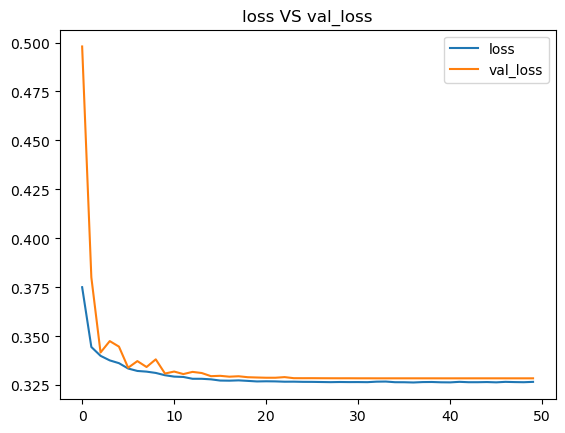

In [6]:
plt.title('loss VS val_loss')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

The data converge gradually in the early stage and the simulated values are closer to the actual values, but the accuracy is only about 50%.

#### Now that the network is trained, visualize the results. Here are two sets of images that the model encodes then decodes. The first is taken out of the test set, the second is random noise.Between the two images is displayed the encoded representation of the input images (two variables).

1/1 [==============================] - 0s 96ms/step


2022-12-05 21:20:40.421291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 21:20:40.534419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


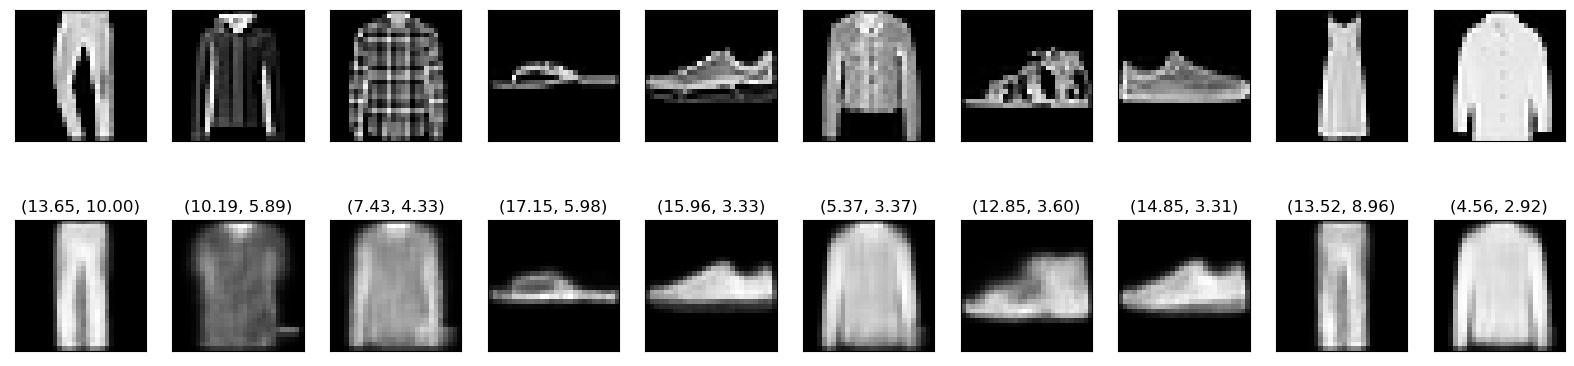

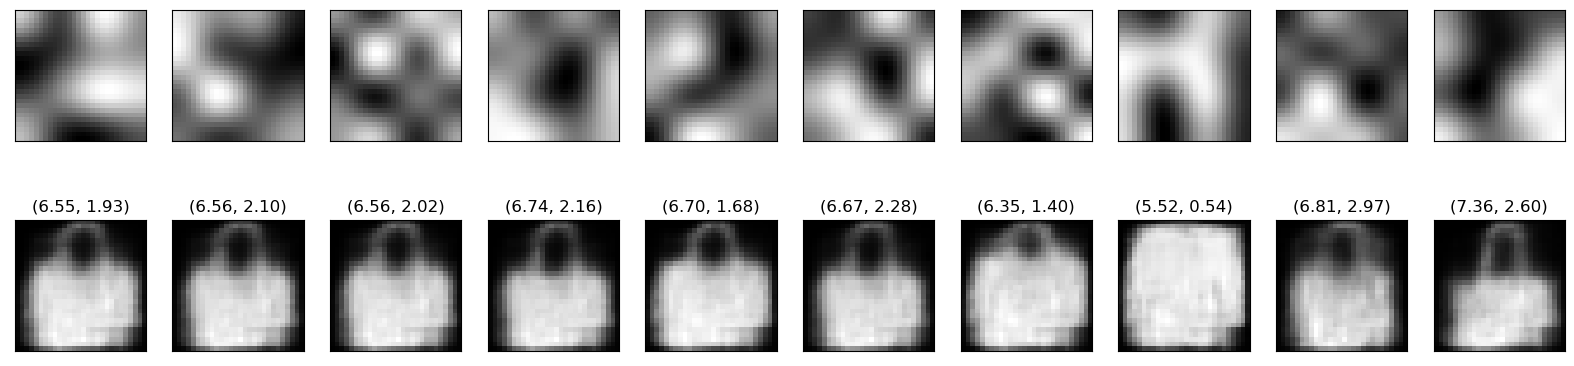

In [7]:
def get_triple(inputs):
    latent_repr = encoder.predict(inputs)
    outputs = decoder.predict(latent_repr)
    latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))

    return inputs, latent_repr, outputs

def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n, figsize=(2*n, 5))
    for i in range(n):
        axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
show_encodings(*get_triple(testX[5:15]))
inputs = np.random.random(size=(10, 4, 4, 1))
inputs = scipy.ndimage.zoom(inputs, (1, 7, 7, 1))
show_encodings(*get_triple(inputs))

### Compare this approach to other common dimensionality reduction techniques: PCA and T-SNE. We will do this by reducing the 784-dimensional space of the images to two using a technique we want to test. Then we will plot the distribution of the ten classes in the new two-dimensional space and see how separated they are.

313/313 [==============================] - 1s 2ms/step


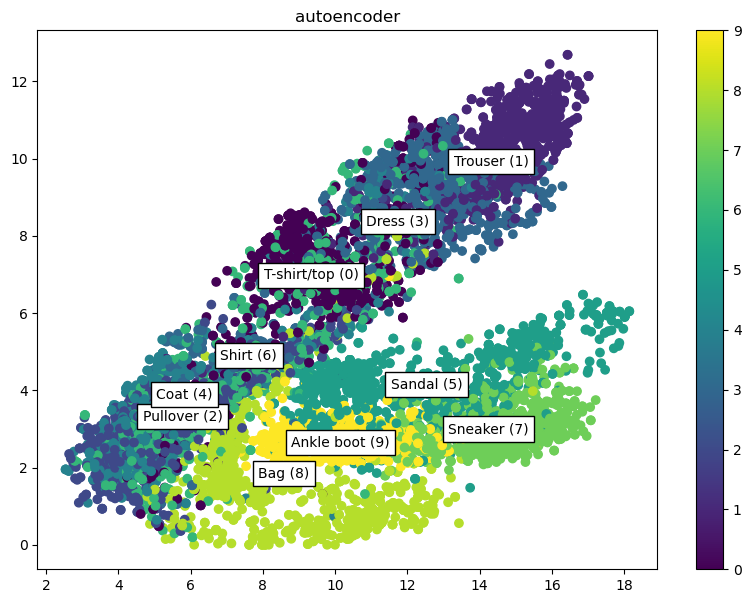

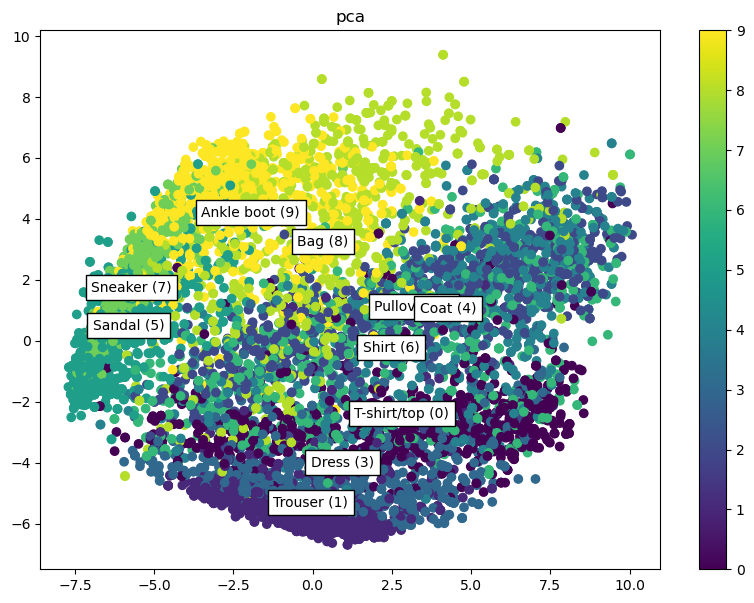

/Users/ava/opt/conda/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ava/opt/conda/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


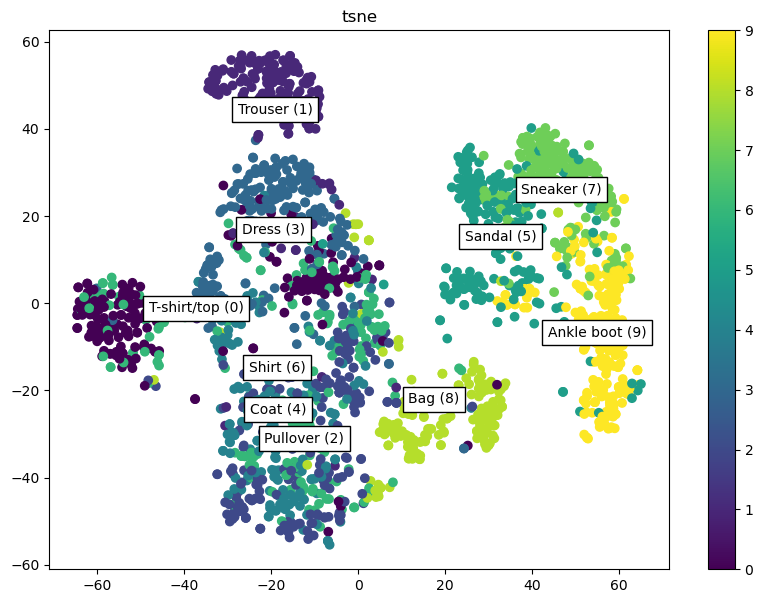

10/10 [==============================] - 0s 7ms/step


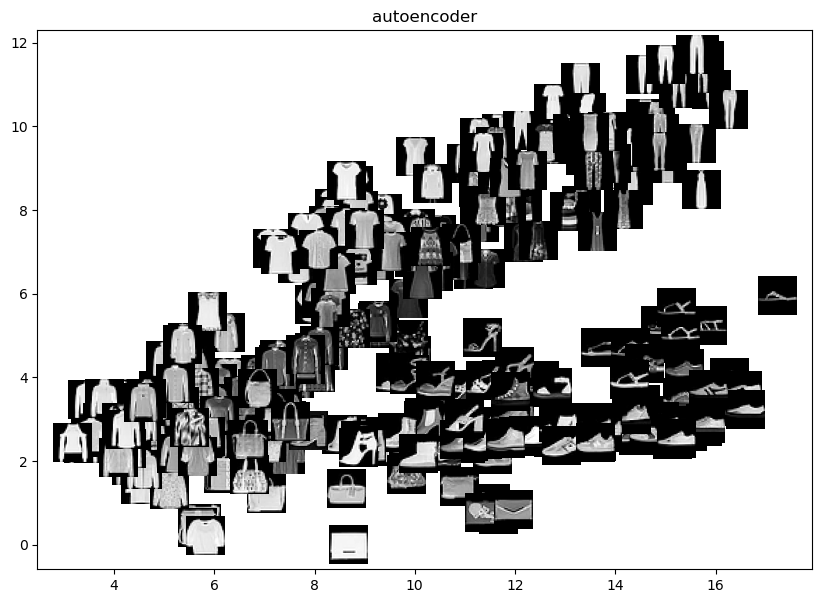

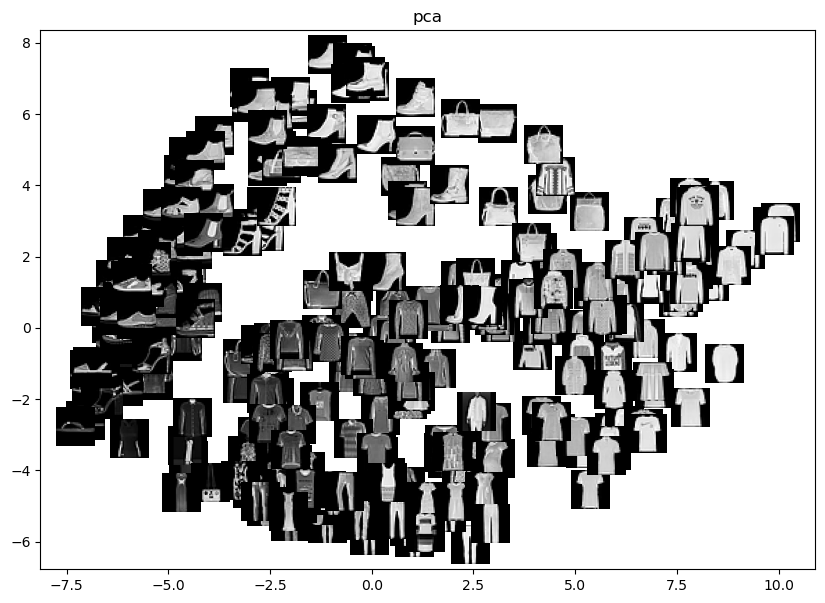

/Users/ava/opt/conda/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ava/opt/conda/envs/tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


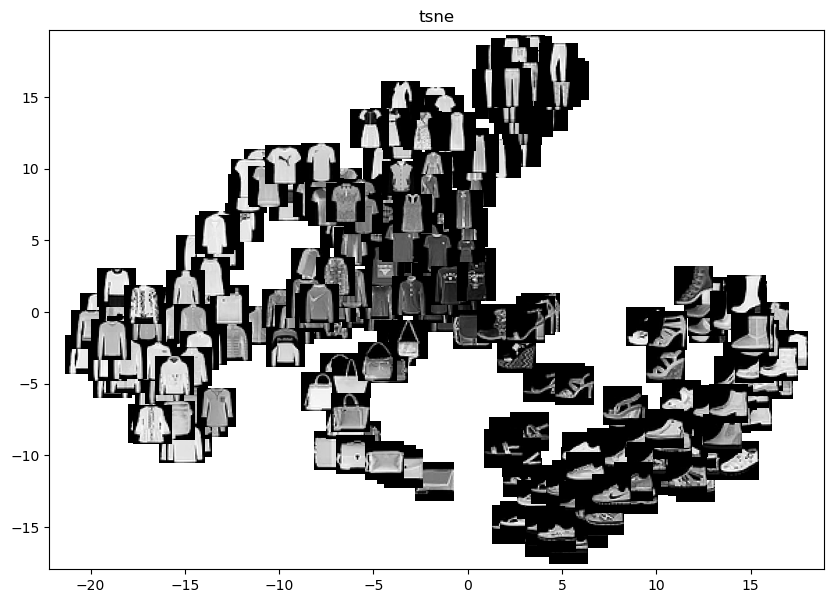

In [8]:
def plot_latent(mode, count, technique):
    idx = np.random.choice(len(testX), count)
    inputs = testX[idx]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'autoencoder':
        coords = encoder.predict(inputs)
    elif technique == 'pca':
        coords = PCA(n_components=2).fit_transform(inputs.reshape(count, -1))
    elif technique == 'tsne':
        coords = TSNE(n_components=2).fit_transform(inputs.reshape(count, -1))

    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = testy[idx]
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{} ({})'.format(labeldict[i], i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

plot_latent('dots', 10000, 'autoencoder')
plot_latent('dots', 10000, 'pca')
plot_latent('dots', 2000, 'tsne')

plot_latent('imgs', 300, 'autoencoder')
plot_latent('imgs', 300, 'pca')
plot_latent('imgs', 300, 'tsne')

### Create fake images using GAN generative architectures.

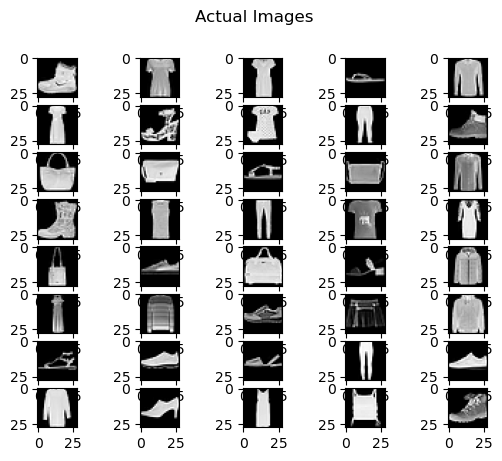

In [9]:
fig,axe=plt.subplots(8,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(8):
    for j in range(5):
        axe[i,j].imshow(trainX[idx].reshape(28,28),cmap='gray')
        idx+=10

#### Generator
The main goal of the Generator is to fool the Discriminator by generating images that look like real images and thus makes it harder for the Discriminator to classify images as real or fake.The Generator Model generates new images by taking a fixed size random noise as an input. Generated images are then fed to the Discriminator Model.

In [10]:
from keras.models import Sequential
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

#### Discriminator
The Discriminator Model takes an image as an input (generated and real) and classifies it as real or fake.
Generated images come from the Generator and the real images come from the training data.
The discriminator model is the simple binary classification model.

In [11]:
from keras.models import Sequential
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 28, 28, 1)         2         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128)              

In [13]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False
GAN.compile(optimizer='adam',loss='binary_crossentropy')

Currently on Epoch 1


2022-12-05 21:20:50.104444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 21:20:50.466184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 21:20:51.004793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 82ms/step


2022-12-05 21:21:16.975671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


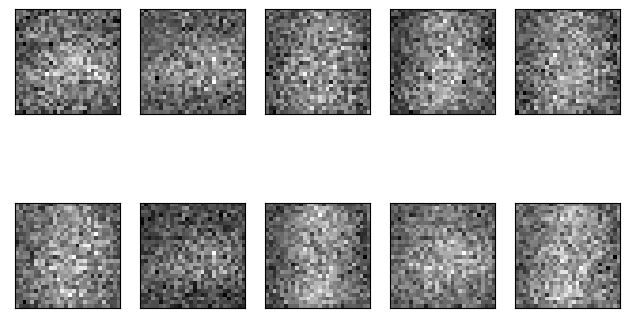

Currently on Epoch 2
Currently on Epoch 3
Currently on Epoch 4
Currently on Epoch 5
Currently on Epoch 6
Currently on Epoch 7
Currently on Epoch 8
Currently on Epoch 9
Currently on Epoch 10
Currently on Epoch 11
1/1 [==============================] - 0s 10ms/step


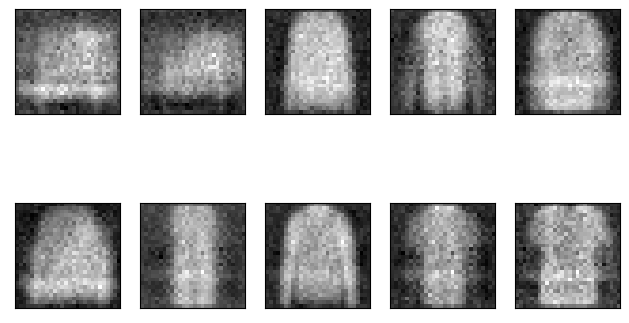

Currently on Epoch 12
Currently on Epoch 13
Currently on Epoch 14
Currently on Epoch 15
Currently on Epoch 16
Currently on Epoch 17
Currently on Epoch 18
Currently on Epoch 19
Currently on Epoch 20
Currently on Epoch 21
1/1 [==============================] - 0s 9ms/step


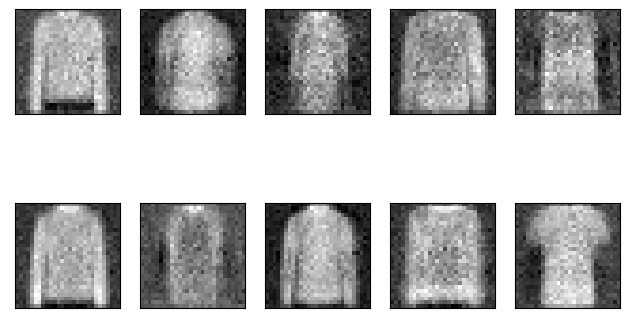

Currently on Epoch 22
Currently on Epoch 23
Currently on Epoch 24
Currently on Epoch 25
Currently on Epoch 26
Currently on Epoch 27
Currently on Epoch 28
Currently on Epoch 29
Currently on Epoch 30
Currently on Epoch 31
1/1 [==============================] - 0s 10ms/step


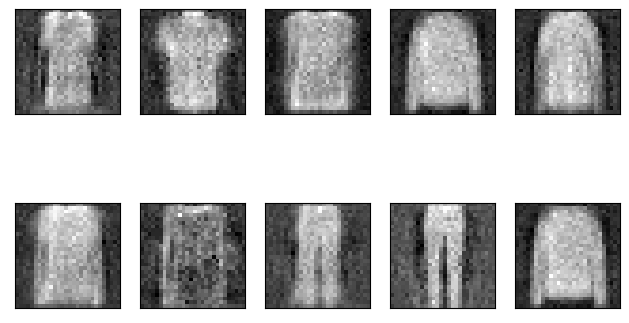

Currently on Epoch 32
Currently on Epoch 33
Currently on Epoch 34
Currently on Epoch 35
Currently on Epoch 36
Currently on Epoch 37
Currently on Epoch 38
Currently on Epoch 39
Currently on Epoch 40
Currently on Epoch 41
1/1 [==============================] - 0s 10ms/step


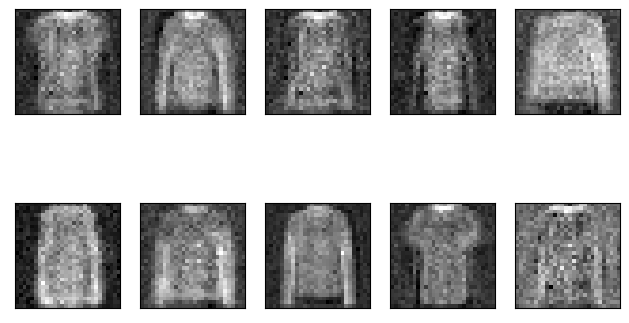

Currently on Epoch 42
Currently on Epoch 43
Currently on Epoch 44
Currently on Epoch 45
Currently on Epoch 46
Currently on Epoch 47
Currently on Epoch 48
Currently on Epoch 49
Currently on Epoch 50
Training is complete


In [14]:
epochs = 50
batch_size = 100
noise_shape=100
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    
    for i in range(trainX.shape[0]//batch_size):
            
        noise=np.random.normal(size=[batch_size,noise_shape])
       
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = trainX[i*batch_size:(i+1)*batch_size]
       
        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)
        
        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)
        
        
        #training generator 
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
        
        
        
       
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

        
        
print('Training is complete')

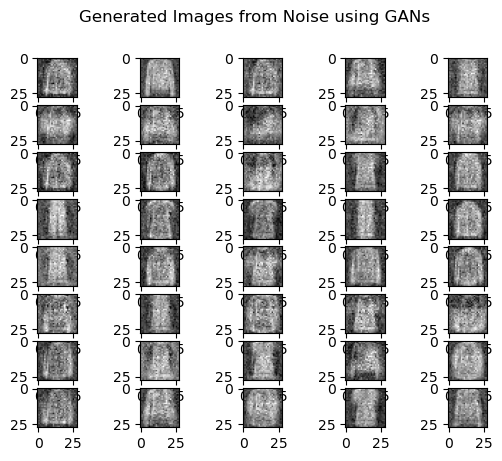

In [15]:
fig,axe=plt.subplots(8,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(8):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1

#### we can see for shirt and dress are more close to the reality but for pullover,it's kind hard to recognize. The result is also fit the analysisof Autoencoders.

### References:
1.Autoencoder - https://www.kaggle.com/code/nathra/fashion-mnist-convolutional-autoencoder/notebook  
2.Dataset - https://www.kaggle.com/datasets/zalando-research/fashionmnist  
3.GANs - https://www.analyticsvidhya.com/blog/2021/06/a-detailed-explanation-of-gan-with-implementation-using-tensorflow-and-keras/